# Comparison between Tikhonov extraction and classic box extraction
- simulation without tilt (so box extraction not disadvantaged)
- Constant throughtput

# Imports

## For plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Imports from standard packages

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits

## Local imports

In [3]:
from overlap import TrpzOverlap
from classic import OptimalExtract
from utils import get_soss_grid, grid_from_map, oversample_grid
from throughput import ThroughputSOSS

# Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
P1 = fits.open("Ref_files/spat_profile_m1.fits")[0].data.squeeze()
P2 = fits.open("Ref_files/spat_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

# Remove the tilt from wv maps
wv_1 = np.tile(wv_1[50,:], (256, 1))
wv_2 = np.tile(wv_2[50,:], (256, 1))

# Setup for simulation

## Wavelength grid

In [5]:
lam_simu = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=15)

## Initiate a simulation.

In [6]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu = TrpzOverlap([P1,P2], [wv_1,wv_2], lam_grid=lam_simu, thresh=1e-8, c_kwargs={'thresh':1e-6})

# ***** WARNING *******
# Since it's oversampled, may take some time to initiate
# (mostly because of the convolution matrix)

# Use PHOENIX spectrum

## Read stellar spectrum

In [7]:
path = "/Users/antoinedb/Documents/Doctorat/SOSS/"
file = "Z-0.0-lte02300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-n_os-15.npz"
spec_file = np.load(path+file)

In [8]:
wv, flux = spec_file["wave"], spec_file["flux"]
flux_interp = interp1d(wv, flux, kind="cubic", bounds_error=False, fill_value=0.)

## Inject spectrum

In [9]:
# Generate flux to inject
flux = flux_interp(lam_simu)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
# flux *= 1e12
# flux *= 1e9
flux /= 1e3

# Inject order 1 and 2 separately (we don't want any contamination here)
data1 = simu.rebuild(flux, orders=[0])
data2 = simu.rebuild(flux, orders=[1])

<IPython.core.display.Javascript object>


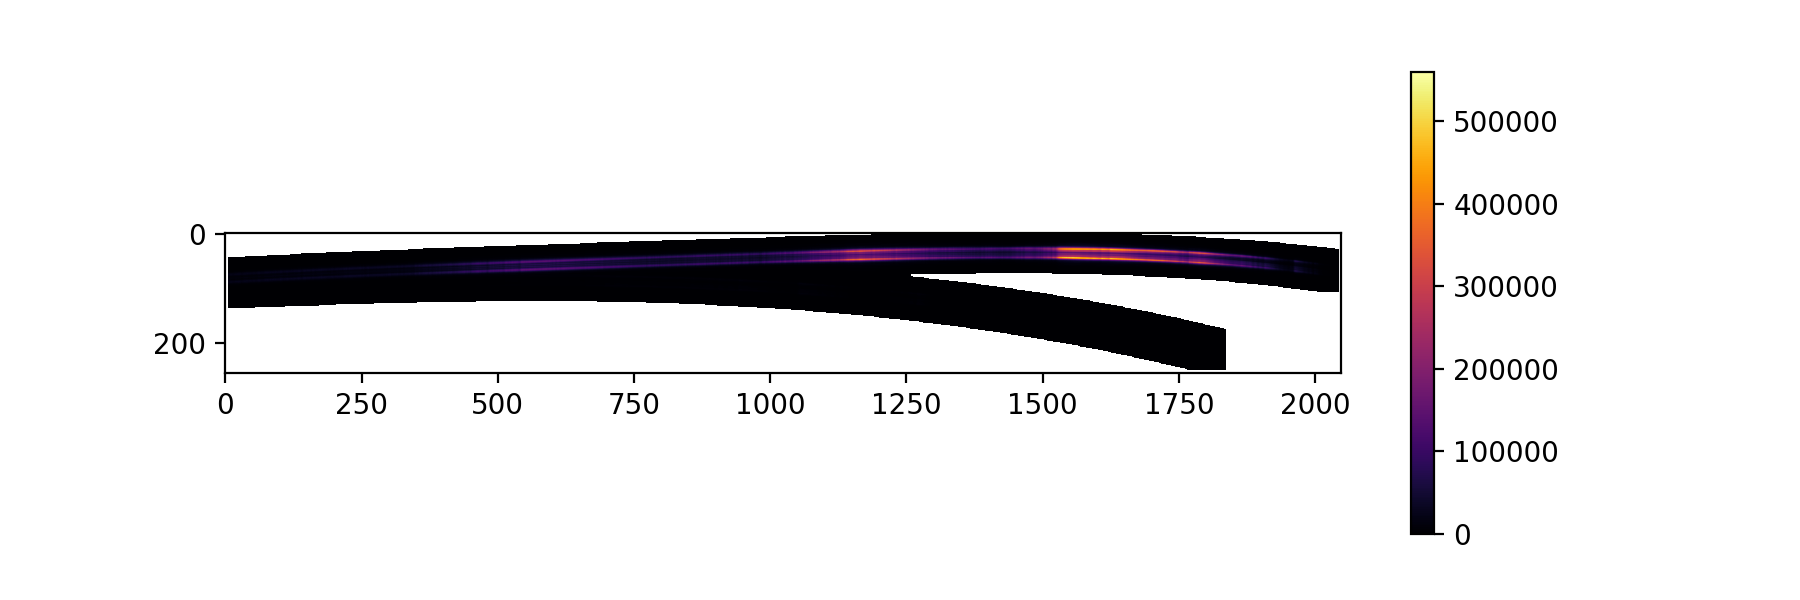

In [10]:
plt.imshow(data1 + data2)
plt.colorbar()

### Save the injected flux at each resulution

In [10]:
# Compute injected convolved flux for each orders
f_th_c = [interp1d(simu.lam_grid_c(i_ord),
                   simu.c_list[i_ord].dot(flux),
                   kind='cubic', fill_value="extrapolate")
          for i_ord in range(2)]

## Extraction with Tikhonov

### Build tikhonov matrix

In [23]:
from importlib import reload
import overlap

In [24]:
reload(overlap)
from overlap import TrpzOverlap

In [11]:
# Parameters for extraction
n_os = 4
c_thresh = 1e-5
# t_mat_n_os = 2

In [12]:
# tikho_matrix = TikhoConvMatrix(wv_2, P2, n_os=t_mat_n_os, thresh=c_thresh)

### Extract

In [35]:
lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=n_os)
extra = TrpzOverlap([P1, P2], [wv_1, wv_2], scidata=data1 + data2,
                    lam_grid=lam_grid, thresh=1e-5,
                    c_kwargs={'thresh': c_thresh})

In [36]:
factors = 10.**(-1*np.arange(11, 19, 0.3))
extra.get_tikho_tests(factors)

Testing factors...
27/27


{'factors': array([1.00000000e-11, 5.01187234e-12, 2.51188643e-12, 1.25892541e-12,
        6.30957344e-13, 3.16227766e-13, 1.58489319e-13, 7.94328235e-14,
        3.98107171e-14, 1.99526231e-14, 1.00000000e-14, 5.01187234e-15,
        2.51188643e-15, 1.25892541e-15, 6.30957344e-16, 3.16227766e-16,
        1.58489319e-16, 7.94328235e-17, 3.98107171e-17, 1.99526231e-17,
        1.00000000e-17, 5.01187234e-18, 2.51188643e-18, 1.25892541e-18,
        6.30957344e-19, 3.16227766e-19, 1.58489319e-19]),
 'solution': array([[ 1.58313669e+07,  1.58313670e+07,  1.58313670e+07, ...,
          7.50137488e+08,  6.37187252e+08,  4.54061005e+08],
        [ 1.61372287e+07,  1.61372289e+07,  1.61372289e+07, ...,
          7.22605469e+08,  6.13796853e+08,  4.37393027e+08],
        [ 1.31938357e+07,  1.31938375e+07,  1.31938372e+07, ...,
          6.95938809e+08,  5.91141562e+08,  4.21248887e+08],
        ...,
        [ 2.01340993e+07,  2.01268068e+07,  2.01124605e+07, ...,
         -5.25191428e+15, -4.42

<IPython.core.display.Javascript object>


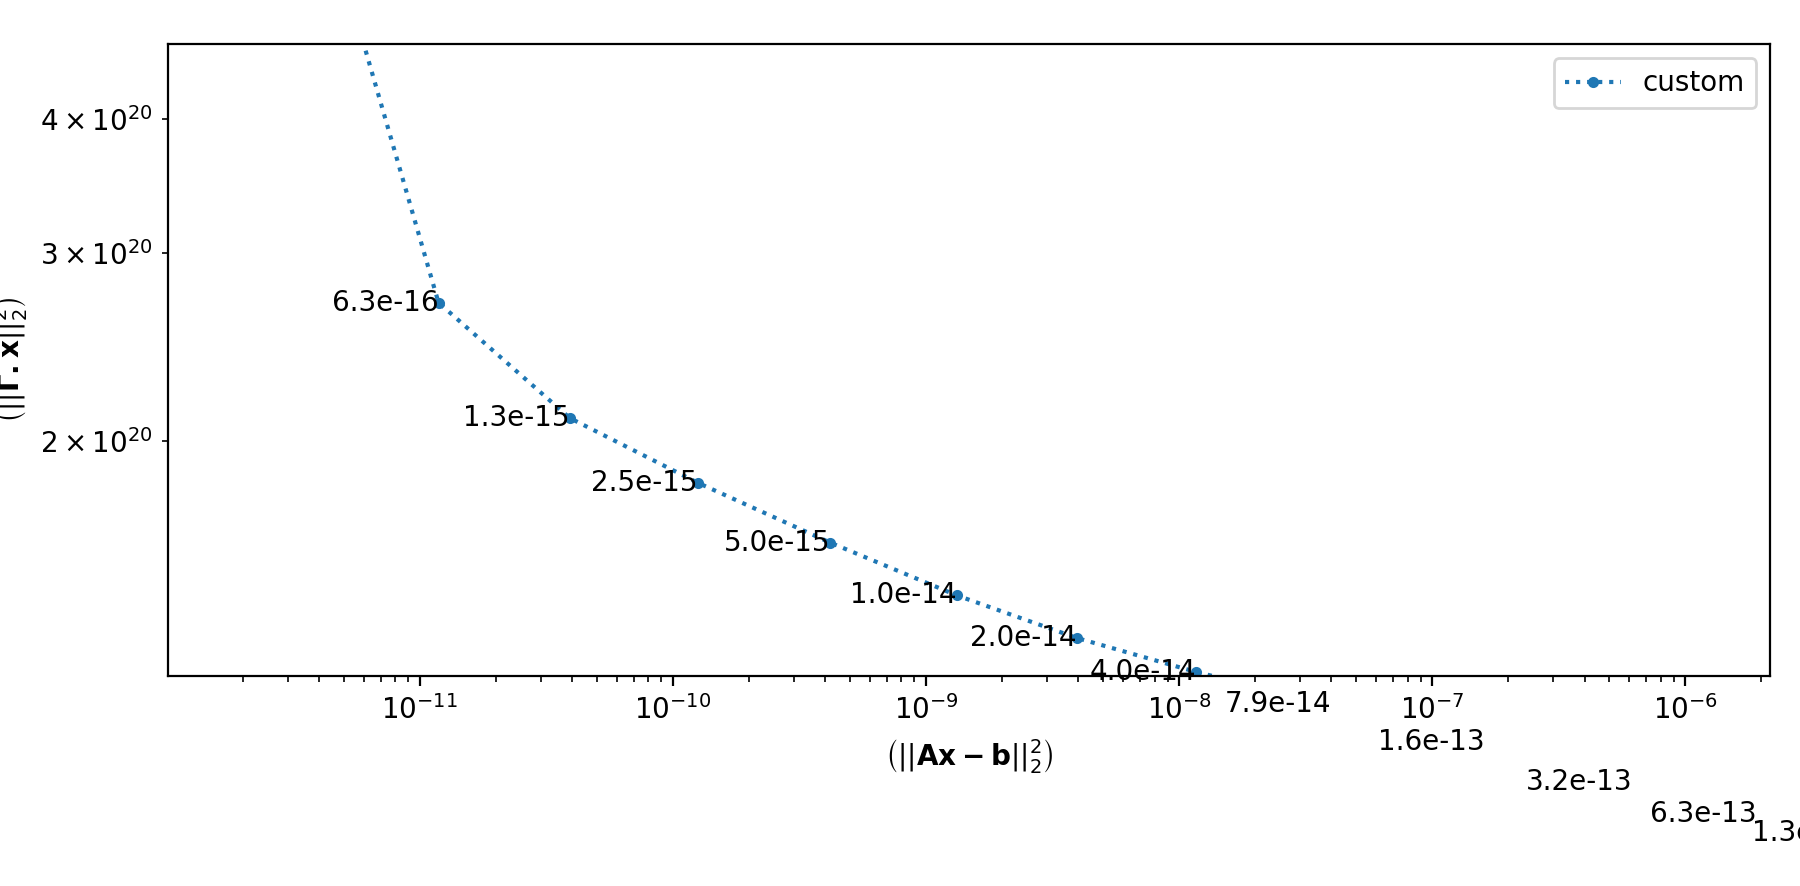

In [37]:
extra.tikho.l_plot()
plt.tight_layout()

In [43]:
f_k = extra.extract(tikhonov=True, tikho_kwargs={'factor': 1.3e-15})
# f_k = extra.extract()

<IPython.core.display.Javascript object>


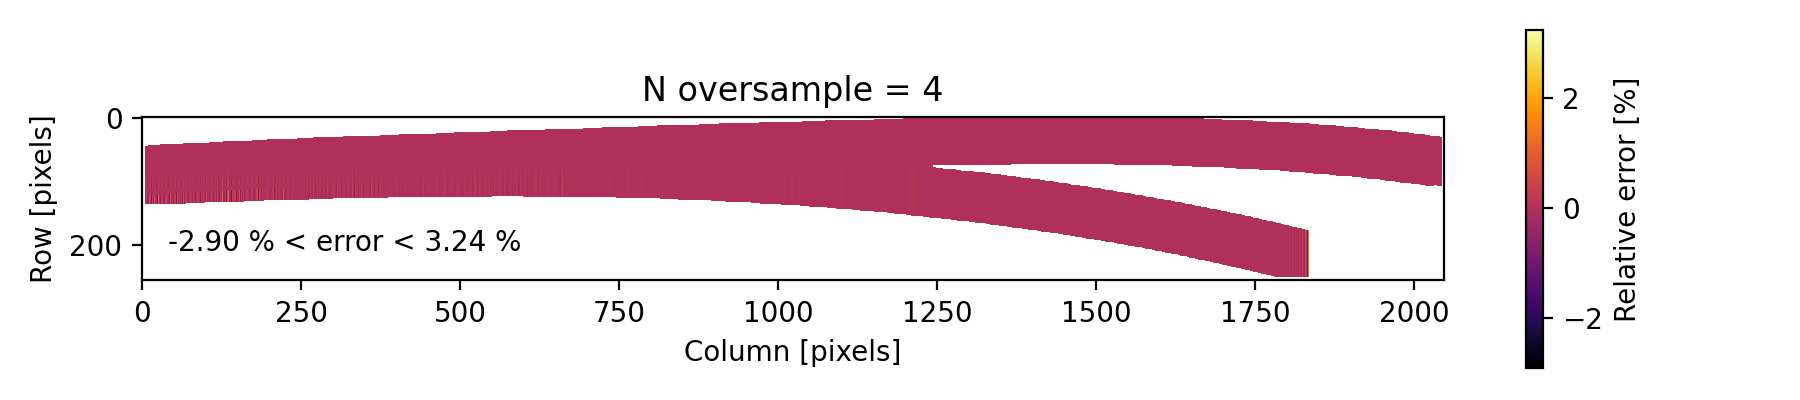

<IPython.core.display.Javascript object>


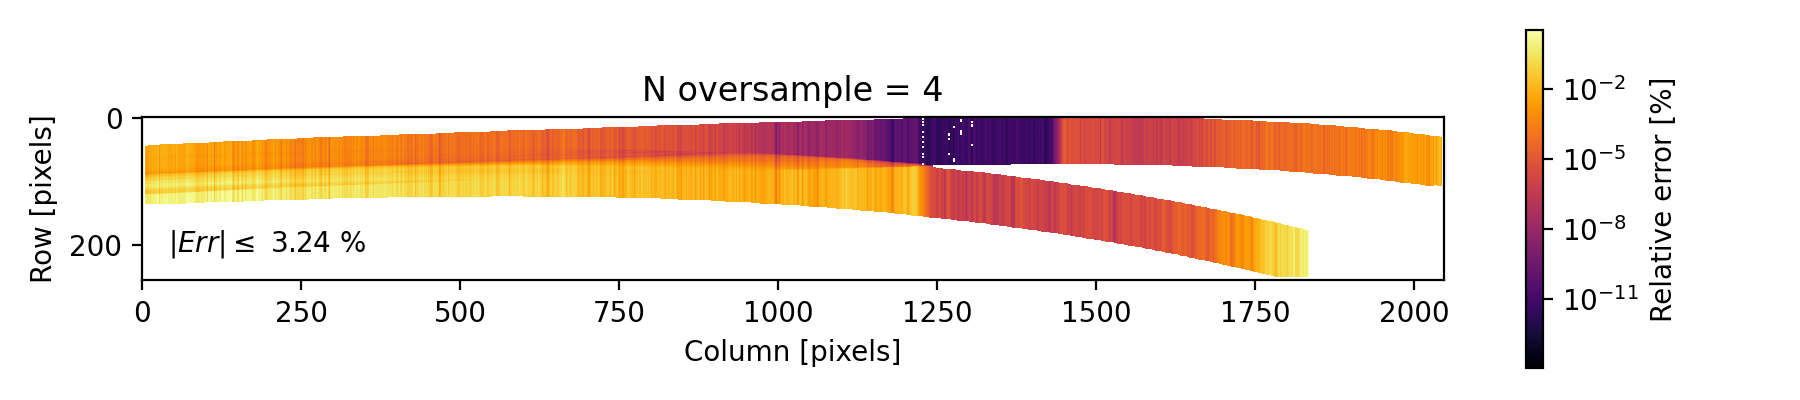

<IPython.core.display.Javascript object>


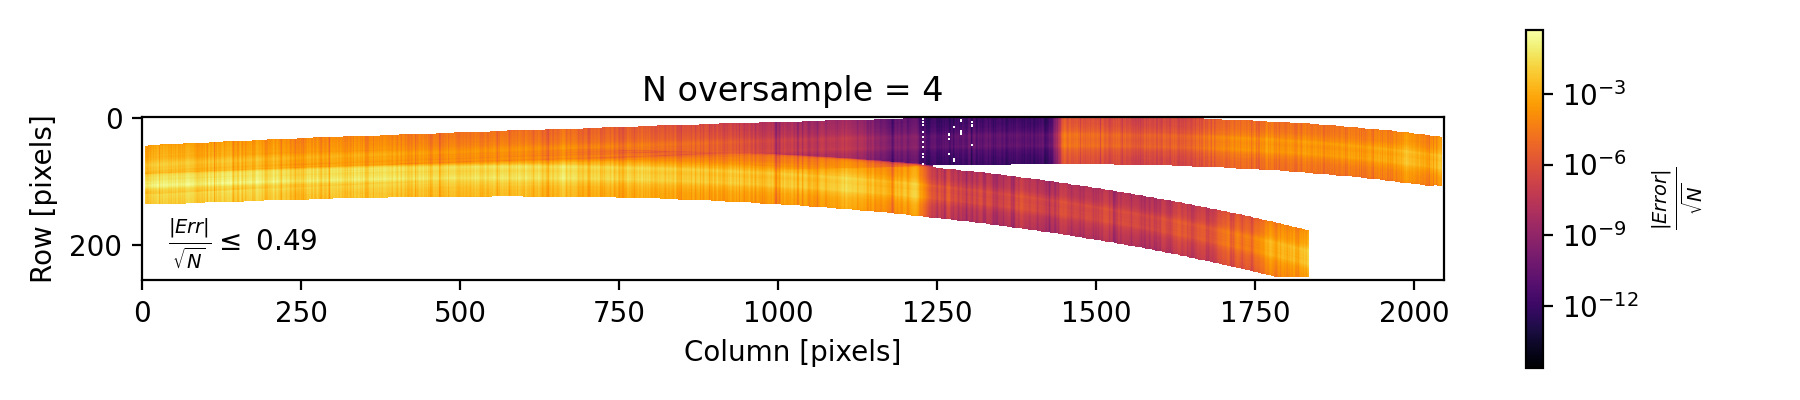

In [133]:
scidata = data1 + data2
rebuilt = extra.rebuild(f_k)

plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_os))
plt.imshow((rebuilt-scidata)/scidata * 100)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,210, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_os))
plt.imshow(np.abs(rebuilt-scidata)/scidata * 100, norm=LogNorm())
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,210, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_os))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm())
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,210, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

<IPython.core.display.Javascript object>


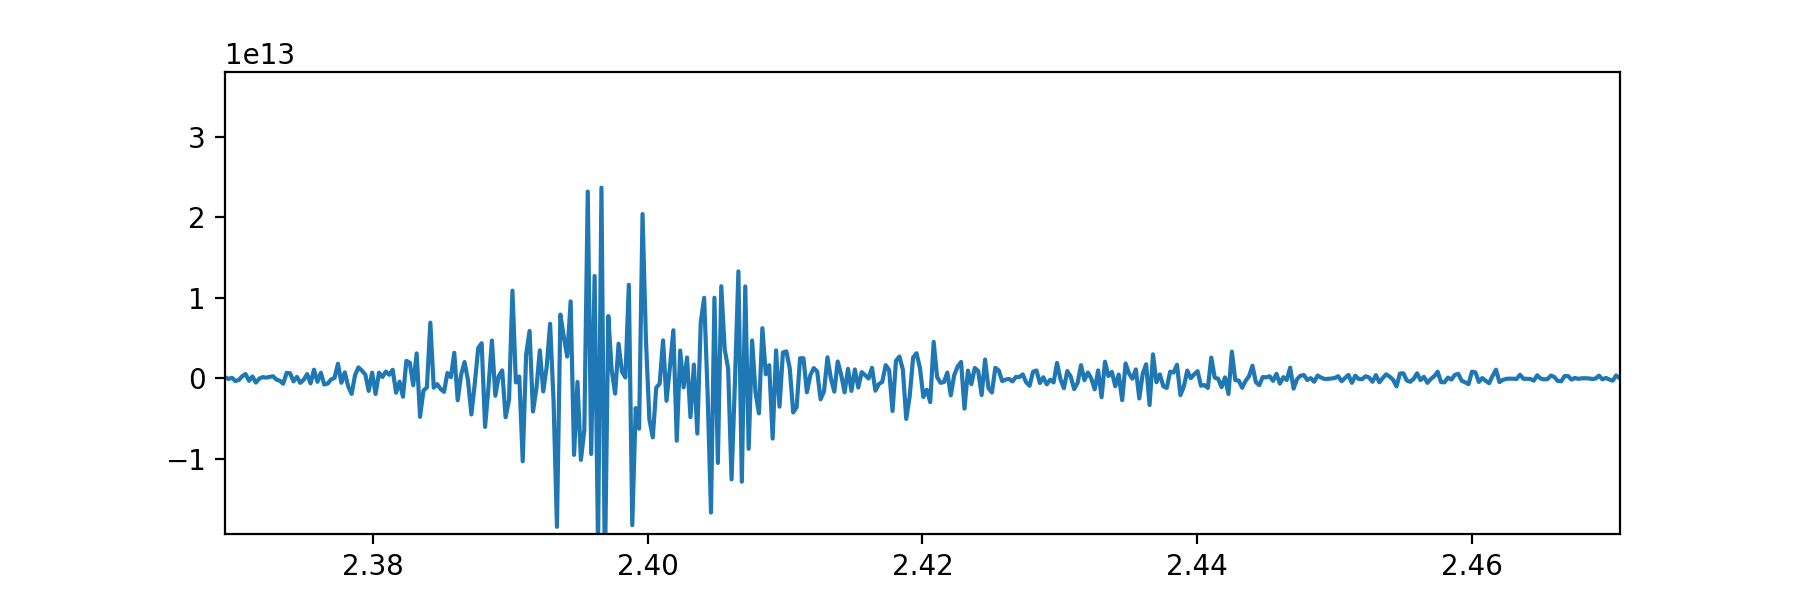

In [40]:
plt.plot(extra.lam_grid, f_k)

### Bin f_k to pixels

In [61]:
def plot_bin_sln(self, *args, fig=None, ax=None, grid_pix=None, f_bin=None, 
                 ylabel="Flux", xlabel=r"Wavelength [$\mu$m]", plot_kwargs=None, **kwargs):
    """
    Plot extracted spectrum integrated over pixels

    Parameters
    ----------
    args: 
        Other arguments passed plot function as follow:
        `plt.plot(x, y, *args, **plot_kwargs)`
    f_k: array-like
        Flux projected on the wavelength grid
    fig: matplotlib figure, optional
        Figure to use for plot
        If not given and ax is None, new figure is initiated
    ax: matplotlib axis, optional
        axis to use for plot. If not given, a new axis is initiated.
    i_ord: int, optional
        index of the order to plot.
        Default is 0 (so the first order given).
    ylabel: str, optional
        Label of y axis
    xlabel: str, optional
        Label of x axis
    kwargs:
        kwargs to be passed to `self.bin_to_bixel` method
    Output
    ------
    fig, ax
    """

    # Manage method's inputs
    # ... for plot inputs
    fig, ax = self._check_plot_inputs(fig, ax)
    if plot_kwargs is None:
        plot_kwargs = {}
    # ... binning inputs
    if f_bin is None:
        grid_pix, f_bin = self.bin_to_pixel(grid_pix=grid_pix, **kwargs)

    # Plot injected flux
    ax.plot(grid_pix, f_bin, *args, **plot_kwargs)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    return fig, ax

def plot_bin_err(self, grid_pix, f_bin_th, *args, fig=None, ax=None, f_bin=None, 
                 error='relative', ylabel='Error', xlabel=r"Wavelength [$\mu$m]",
                 plot_kwargs=None, **kwargs):
    """
    Plot extracted spectrum integrated over pixels

    Parameters
    ----------
    args: 
        Other arguments passed plot function as follow:
        `plt.plot(x, y, *args, **plot_kwargs)`
    f_k: array-like
        Flux projected on the wavelength grid
    fig: matplotlib figure, optional
        Figure to use for plot
        If not given and ax is None, new figure is initiated
    ax: matplotlib axis, optional
        axis to use for plot. If not given, a new axis is initiated.
    i_ord: int, optional
        index of the order to plot.
        Default is 0 (so the first order given).
    ylabel: str, optional
        Label of y axis
    xlabel: str, optional
        Label of x axis
    kwargs:
        kwargs to be passed to `self.bin_to_bixel` method
    Output
    ------
    fig, ax
    """

    # Manage method's inputs
    # ... for plot inputs
    fig, ax = self._check_plot_inputs(fig, ax)
    if plot_kwargs is None:
        plot_kwargs = {}
    # ... binning inputs
    if f_bin is None:
        _, f_bin = self.bin_to_pixel(grid_pix=grid_pix, **kwargs)
        
    # Which error type to plot?
    if error == 'relative':
        y = (f_bin - f_bin_th) / f_bin_th
    elif error == 'absolute':
        y = f_bin - f_bin_th
    elif error == 'to_noise':
        y = (f_bin - f_bin_th) / np.sqrt(f_bin_th)
    elif error == 'relative [ppm]':
        y = 1e6 * (f_bin - f_bin_th) / f_bin_th
    else:
        raise ValueError('`error` argument is not valid.')

    # Add info to ylabel
    ylabel += ' ({})'.format(error)

    # Plot injected flux
    ax.plot(grid_pix, y, *args, **plot_kwargs)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    return fig, ax

In [55]:
pix_center, f_bin_th = [], []
for i_ord in range(2):
    out = simu.bin_to_pixel(f_k=flux, kind='cubic', i_ord=i_ord)
    pix_center.append(out[0])
    f_bin_th.append(out[1])

<IPython.core.display.Javascript object>


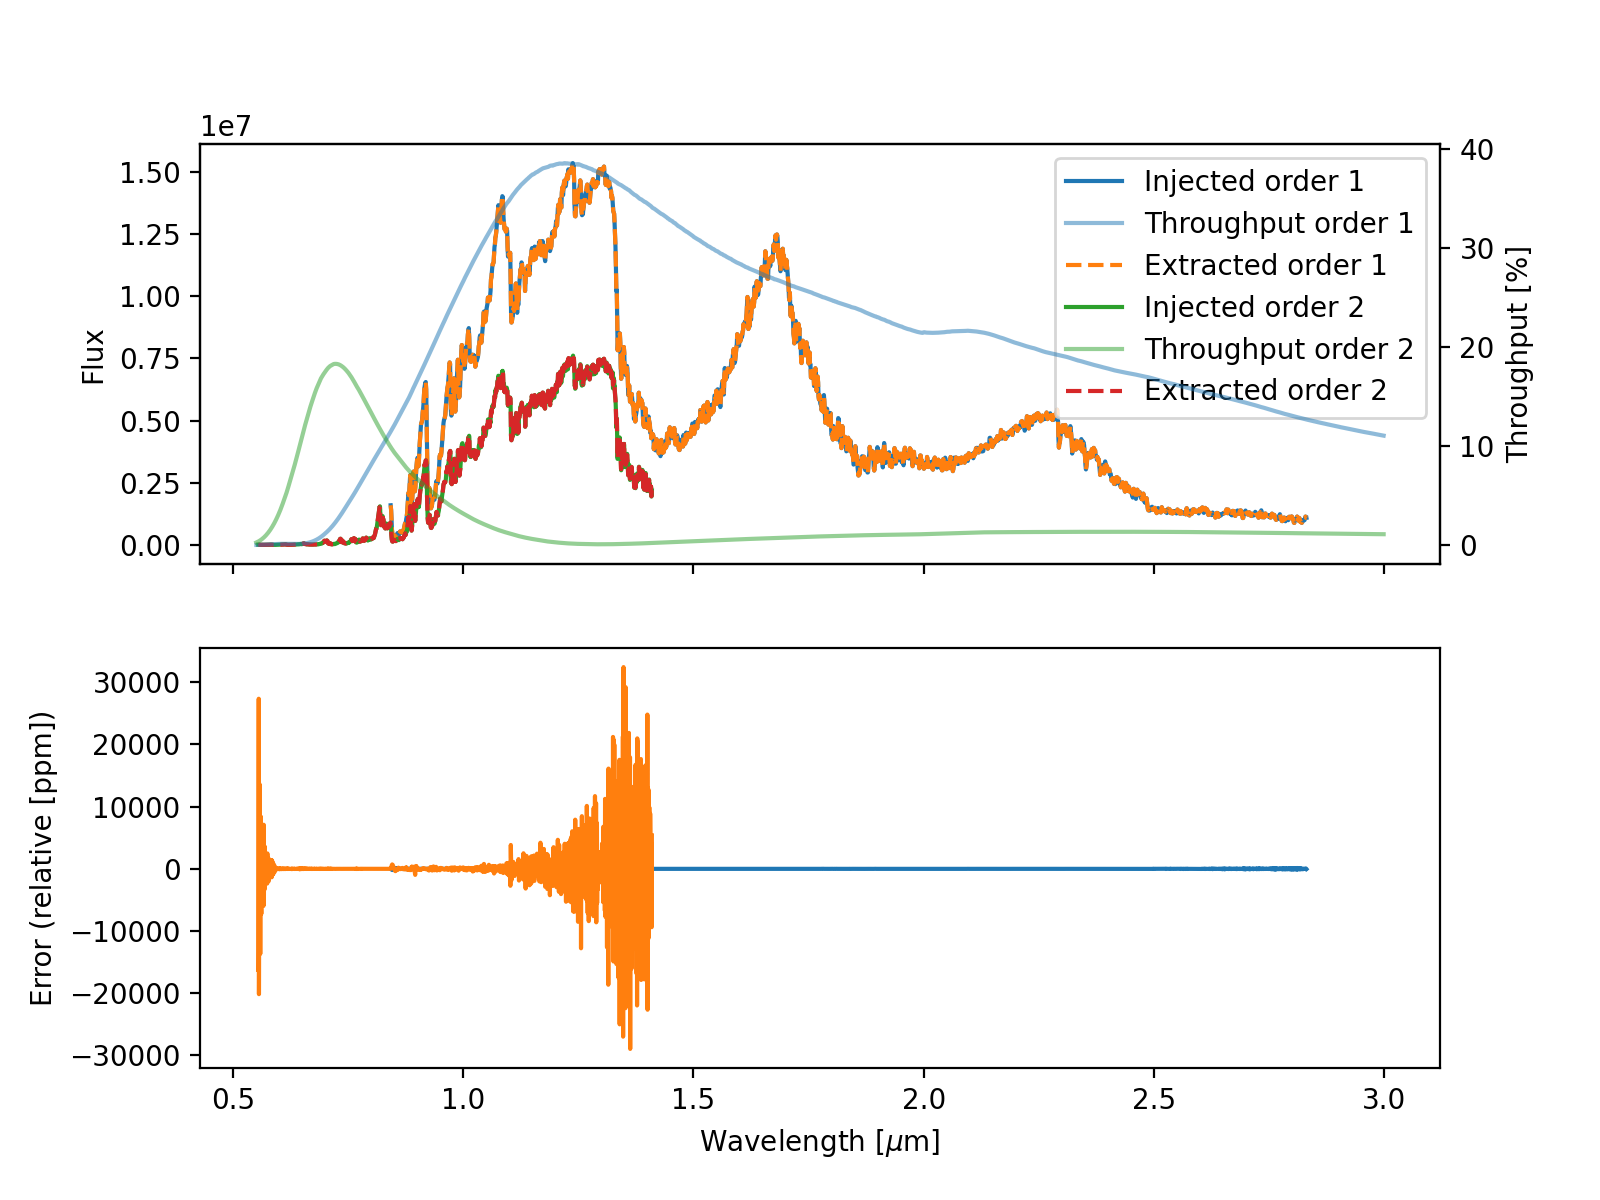

Text(0, 0.5, 'Throughput [%]')

In [64]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax_twin = ax[0].twinx()
lines, labels = [], []
for i_ord in range(extra.n_ord):
    order = extra.orders[i_ord]
    
    ### Top panel ###
    
    _, ax_i = plot_bin_sln(simu, ax=ax[0], f_k=flux, i_ord=i_ord)
    lines.append(ax_i.get_lines()[-1])
    labels.append(f"Injected order {order}")
    
    c_ax = lines[-1].get_color()
    lines += ax_twin.plot(extra.lam_grid, 100 * extra.t_list[i_ord], color=c_ax, alpha=0.5)
    labels.append(f"Throughput order {order}")
    
    _, ax_i = plot_bin_sln(extra, "--", ax=ax[0], f_k=f_k, i_ord=i_ord)
    lines.append(ax_i.get_lines()[-1])
    labels.append(f"Extracted order {order}")
    
    ### Bottom panel ###
    
    label = f"Order {order}"
    plot_bin_err(extra, pix_center[i_ord], f_bin_th[i_ord],
                 ax=ax[1], f_k=f_k, i_ord=i_ord, error="relative [ppm]")
    
    
    
ax[0].legend(lines, labels)
ax[0].set_xlabel(None)
ax_twin.set_ylabel("Throughput [%]")

In [21]:
pix_center, bin_val, bin_val_th = [], [], []
for i_ord in range(2):
    f_k_tr = f_k * extra.t_list[i_ord] * extra.lam_grid
    out = extra.bin_to_pixel(f_k=f_k_tr, kind='linear', i_ord=i_ord)
    pix_center.append(out[0])
    bin_val.append(out[1])
    flux_tr = flux * simu.t_list[i_ord] * simu.lam_grid
    bin_val_th.append(simu.bin_to_pixel(f_k=flux_tr, kind='cubic', i_ord=i_ord)[1])

<IPython.core.display.Javascript object>


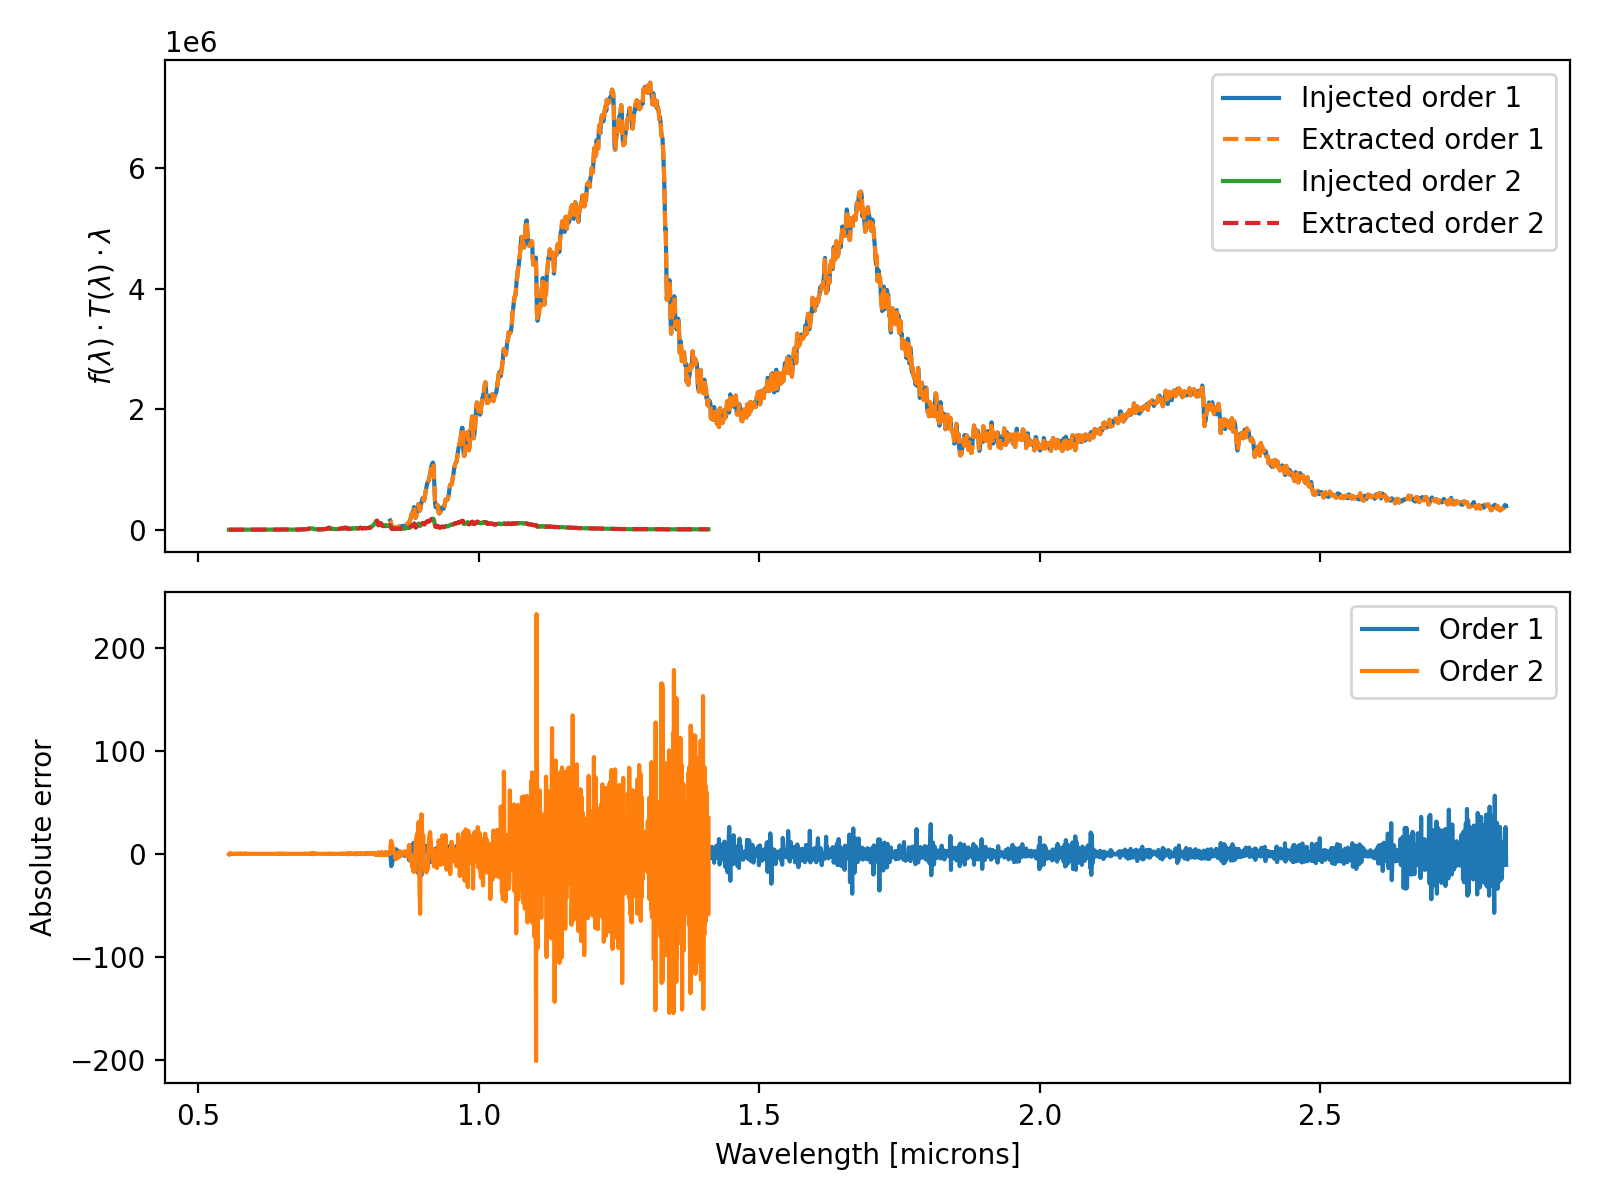

In [22]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,6))
lines, labels = [], []
for i_ord in range(2):
    
    lines += ax[0].plot(pix_center[i_ord], bin_val_th[i_ord])
    labels.append("Injected order {}".format(i_ord + 1))
    
    lines += ax[0].plot(pix_center[i_ord], bin_val[i_ord], '--')
    labels.append("Extracted order {}".format(i_ord + 1))

ax[0].legend(lines, labels)
ax[0].set_ylabel(r"$f(\lambda) \cdot T(\lambda) \cdot \lambda$")

for i_ord in range(2):
    label = "Order {}".format(i_ord + 1)
    error = (bin_val[i_ord] - bin_val_th[i_ord])# / bin_val_th[i_ord]
    ax[1].plot(pix_center[i_ord], error, label=label)
ax[1].legend()
ax[1].set_ylabel("Absolute error")
ax[1].set_xlabel('Wavelength [microns]')

plt.tight_layout()

## Extract with box extraction

In [67]:
from classic import OptimalExtract
from utils import get_lam_p_or_m

In [68]:
def fct_ones(x): return np.ones_like(x)
box_extra = OptimalExtract(np.fliplr(data1), t_ord=fct_ones, p_ord=np.fliplr(P1 > 1e-5), lam_ord=np.fliplr(wv_1))

In [69]:
grid_box, val_box = box_extra.extract()

In [74]:
grid_box_th, val_box_th = simu.bin_to_pixel(f_k=flux*simu.t_list[0]*simu.lam_grid,
                                       grid_pix=grid_box, kind='cubic')

<IPython.core.display.Javascript object>


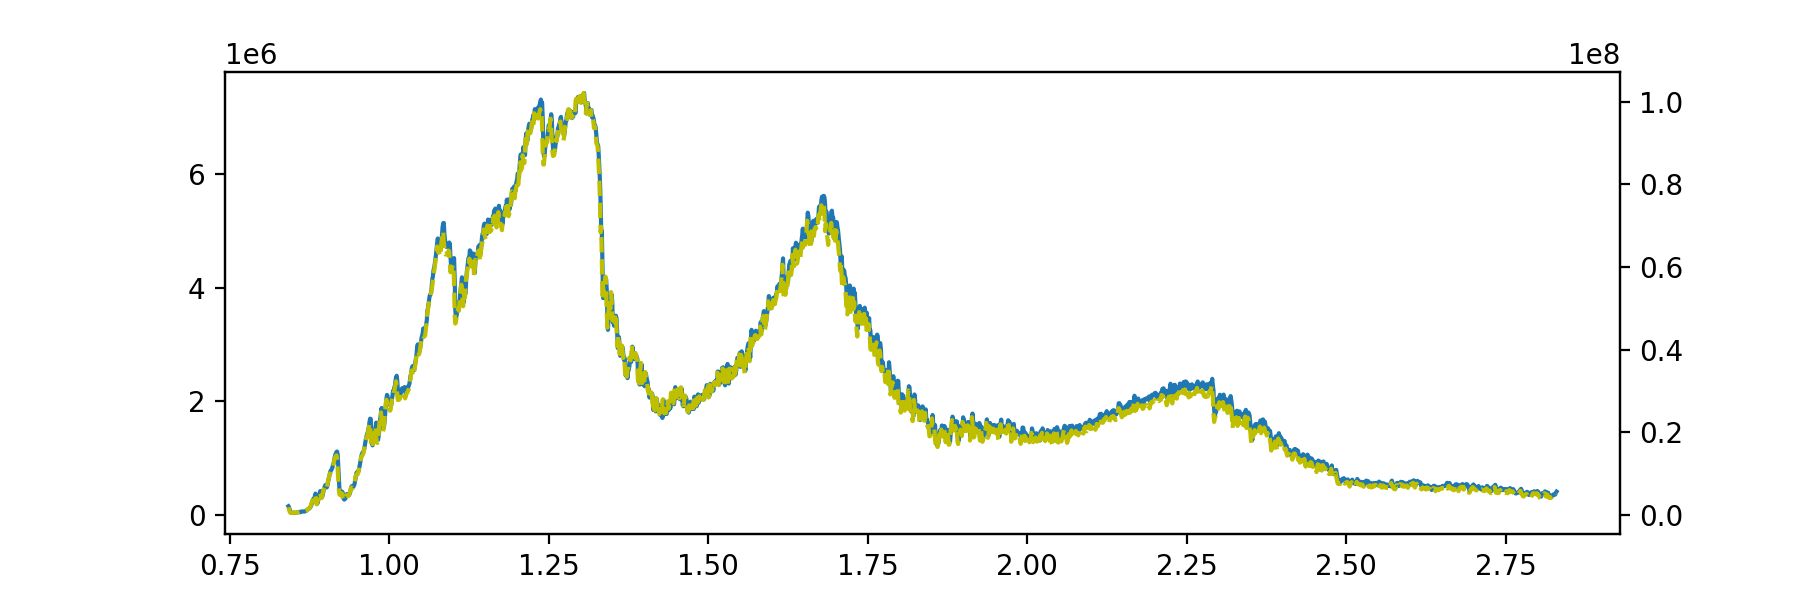

In [75]:
plt.plot(grid_box_th, val_box_th)
ax = plt.gca().twinx()
ax.plot(grid_box, val_box, "y--")

# Test on noisy time serie for a single order

In [76]:
def add_noise(data, bkgrd=20):
    
    data_noisy = data.copy()

    # Add Poisson noise
    data_noisy[np.isnan(data_noisy)] = 0  # Nans to zero
    data_noisy = np.random.poisson(data_noisy)    

    # Add background noise
    data_bkgrd = np.random.normal(scale=bkgrd, size=data_noisy.shape)
    data_noisy = data_noisy + data_bkgrd

    return data_noisy

## First find the best tikhonov factor

In [77]:
data_noisy = add_noise(data1)
sig = np.sqrt(data_noisy + 20.**2)  # Map of expected noise

### Build tikhonov matrix

In [78]:
# Parameters for extraction
n_os = 4
c_thresh = 1e-5
# t_mat_n_os = 2

### Extract

In [79]:
lam_grid = grid_from_map(wv_1, P1, n_os=n_os)
extra = TrpzOverlap([P1], [wv_1], scidata=data_noisy,
                    lam_grid=lam_grid, thresh=1e-5, sig=sig,
                    c_kwargs={'thresh': c_thresh}, orders=[1])

In [80]:
factors = 10.**(-1*np.arange(11, 22, 0.3))
tests = extra.get_tikho_tests(factors)

Testing factors...
37/37


<IPython.core.display.Javascript object>


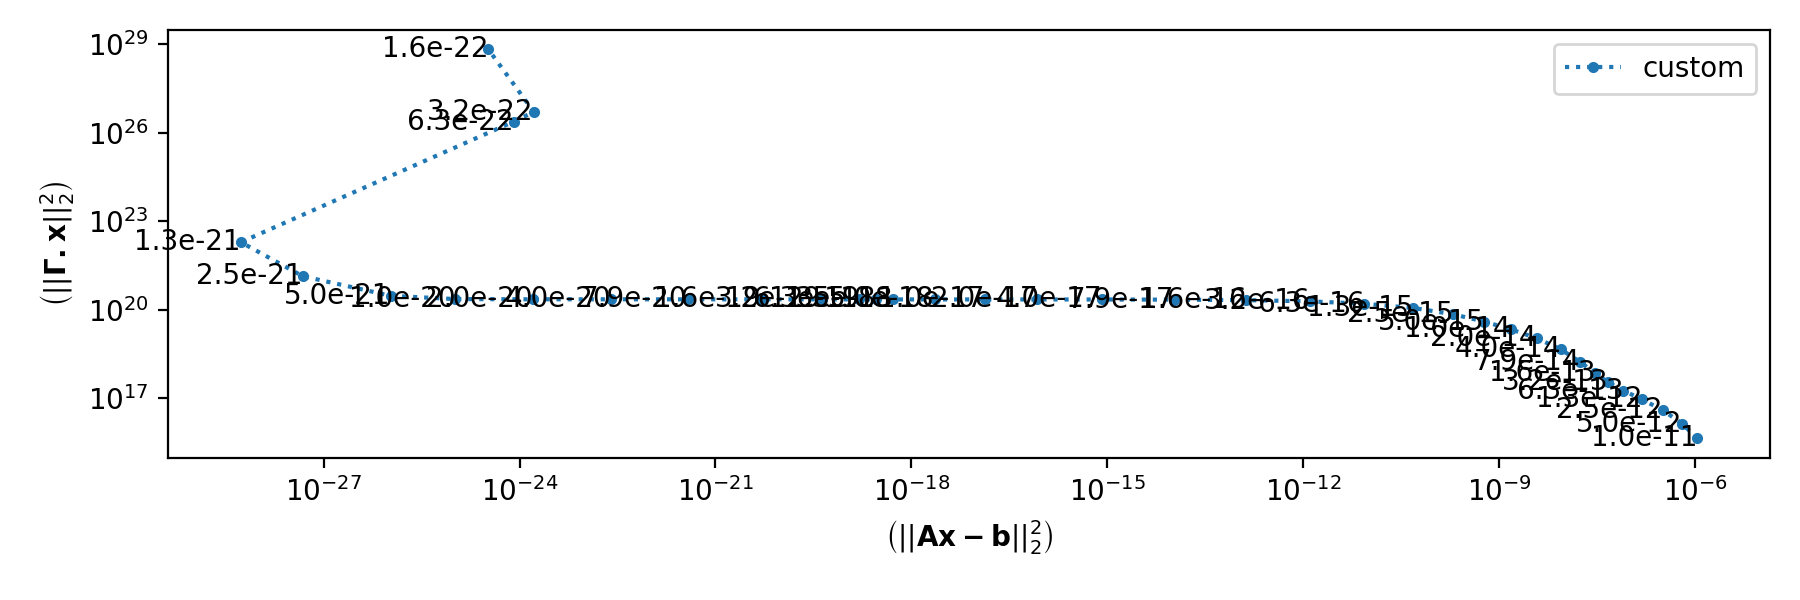

In [81]:
extra.tikho.l_plot()
plt.tight_layout()

## Extract a time serie with both methods

In [82]:
grid_box, val_box = box_extra.extract()
box_p, box_m = get_lam_p_or_m(grid_box)

In [86]:
box_f_bin_list = []
tikho_f_bin_list = []
f_bin_list = []

for i in range(100):
    print(i)
    
    data_noisy = add_noise(data1)
    sig = np.sqrt(data_noisy + 20.**2)  # Map of expected noise
    
    # Box extraction
    box_extra = OptimalExtract(np.fliplr(data_noisy),
                               t_ord=fct_ones,
                               p_ord=np.fliplr(P1 > 1e-5),
                               lam_ord=np.fliplr(wv_1))
    if i == 0:
        grid_box, val_box = box_extra.extract()
        box_p, box_m = get_lam_p_or_m(grid_box)
    else:
        val_box = box_extra.extract()[1]
    box_f_bin_list.append(val_box)
    
    # TIkhonov
    f_k = extra.extract(data=data_noisy,
                        tikhonov=True,
                        tikho_kwargs={'factor':2.0e-20})
    f_k_tr = f_k * extra.t_list[0] * extra.lam_grid
    val_tikho = extra.bin_to_pixel(f_k=f_k_tr, kind='linear',
                                   grid_pix=(box_m, box_p))[1]
    tikho_f_bin_list.append(val_tikho)
    
    # No tikho
    f_k = extra.extract(data=data_noisy)
    f_k_tr = f_k * extra.t_list[0] * extra.lam_grid
    val = extra.bin_to_pixel(f_k=f_k_tr, kind='linear',
                             grid_pix=(box_m, box_p))[1]
    f_bin_list.append(val)

tikho_f_bin_list = np.array(tikho_f_bin_list)
box_f_bin_list = np.array(box_f_bin_list)
f_bin_list = np.array(f_bin_list)

In [87]:
tikho_std = np.std(tikho_f_bin_list/np.mean(tikho_f_bin_list, axis=0), axis=0)
box_std = np.std(box_f_bin_list/np.mean(box_f_bin_list, axis=0), axis=0)
no_tikho_std = np.std(f_bin_list/np.mean(f_bin_list, axis=0), axis=0)

In [168]:
noise_estimate = np.fliplr(np.ma.array(sig, mask=(P1 <= 1e-5)))
noise_estimate = np.sqrt(np.ma.sum(noise_estimate**2, axis=0))
noise_estimate /= np.flip(np.ma.array(data1, mask=(P1 <= 1e-5)).sum(axis=0))
lam_noise = np.flip(wv_1[0, :])

<IPython.core.display.Javascript object>


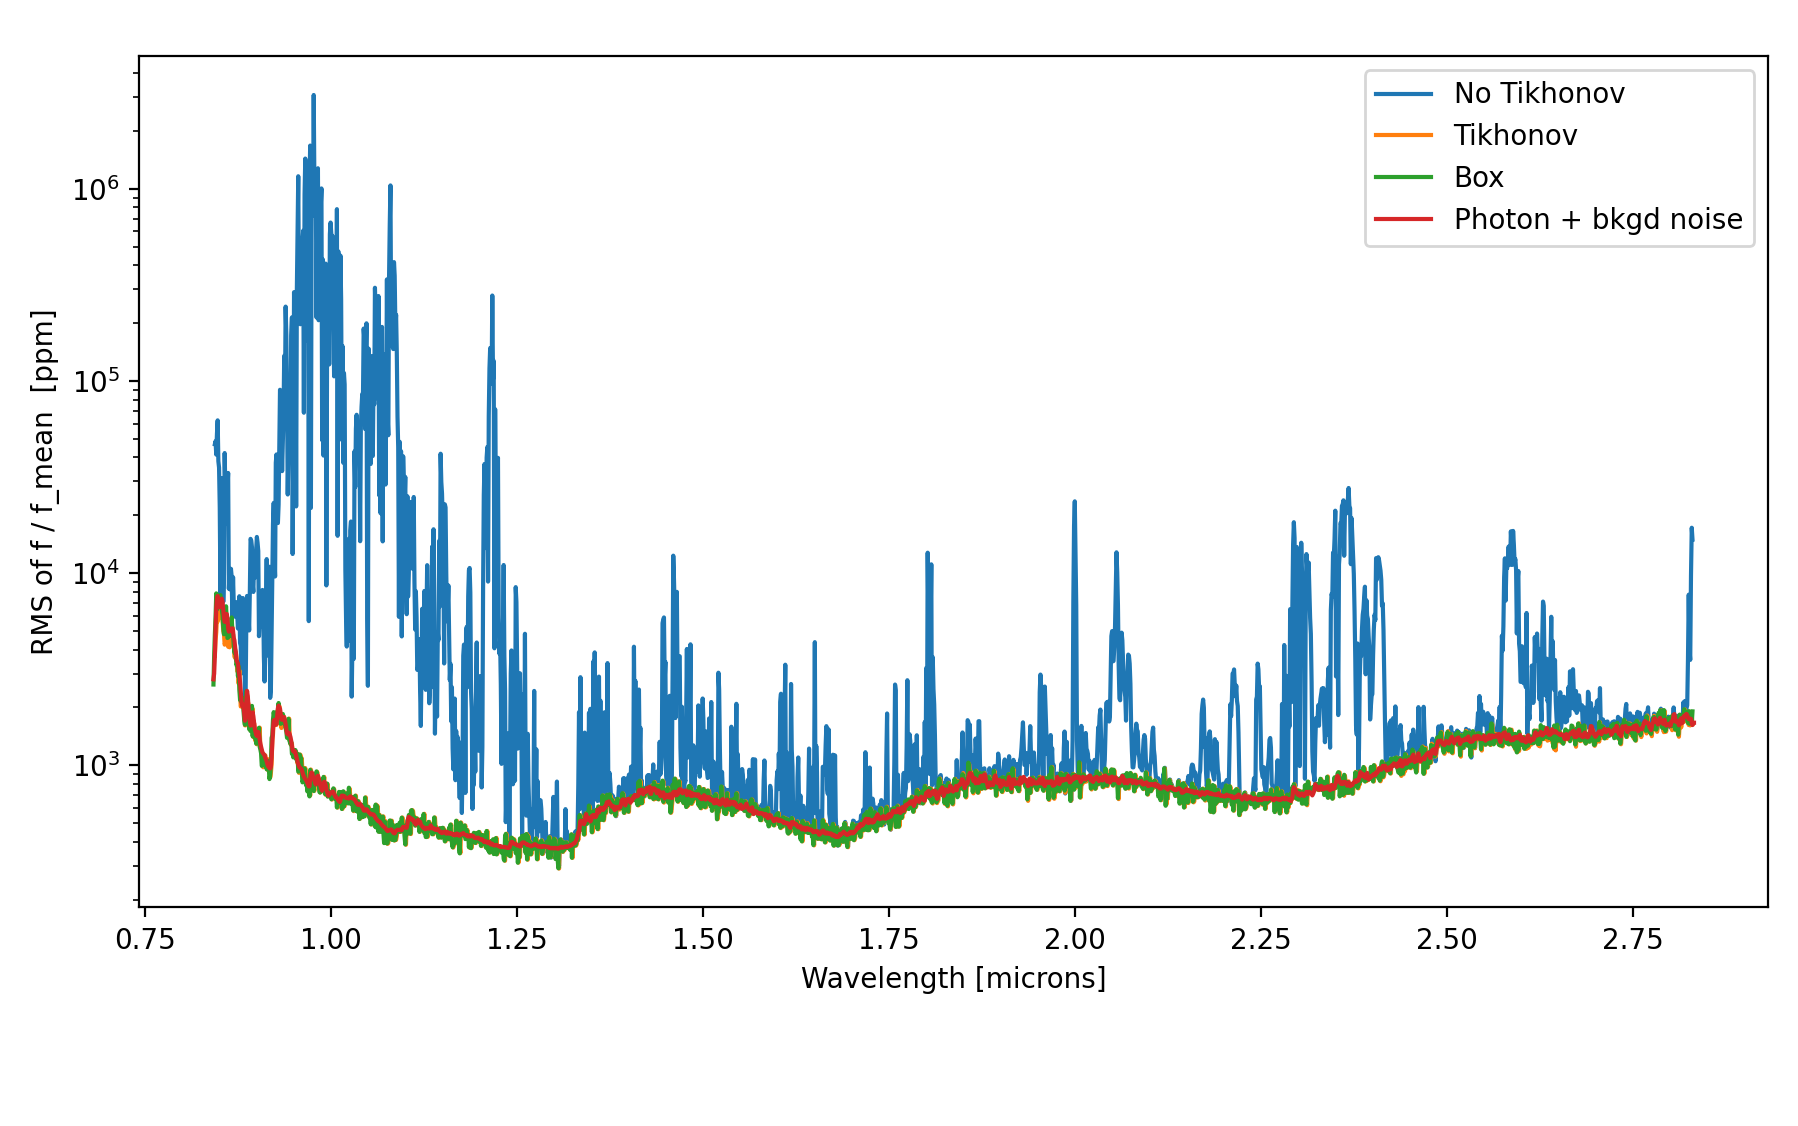

In [171]:
plt.semilogy(grid_box, 1e6 * no_tikho_std, label='No Tikhonov')
plt.semilogy(grid_box, 1e6 * tikho_std, label='Tikhonov')
plt.semilogy(grid_box, 1e6 * box_std, label='Box')
plt.semilogy(lam_noise, 1e6 * noise_estimate, label='Photon + bkgd noise')

plt.legend()
plt.xlabel("Wavelength [microns]")
plt.ylabel("RMS of f / f_mean  [ppm]")

plt.tight_layout()

# Comparison for contaminated extraction
1. Decontaminate 2-D image and extract with box extraction. 
  1. Tikhonov
  2. No Tikhonov
2. Extract directly from contaminated 2-D image (Tikhonov)

A time serie will be use to compute the standard deviation of the extracted spectra. This will serve as a metric to estimate the precision of the extraction.